# Modelagem M5 forecasting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import joblib

### Data

In [4]:
# Carregar o DataFrame exportado anteriormente
df = pd.read_csv('/content/drive/MyDrive/dados_colab/final_df.csv', parse_dates=['date'])

# Verificar o carregamento
print("Formato do DataFrame:", df.shape)
print("Colunas disponíveis:", df.columns.tolist())

Formato do DataFrame: (58449330, 23)
Colunas disponíveis: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'event_name', 'event_type', 'is_event', 'sell_price', 'day', 'week', 'quarter']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58449330 entries, 0 to 58449329
Data columns (total 23 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item_id     object        
 2   dept_id     object        
 3   cat_id      object        
 4   store_id    object        
 5   state_id    object        
 6   d           object        
 7   sales       int64         
 8   date        datetime64[ns]
 9   weekday     object        
 10  wday        int64         
 11  month       int64         
 12  year        int64         
 13  snap_CA     int64         
 14  snap_TX     int64         
 15  snap_WI     int64         
 16  event_name  object        
 17  event_type  object        
 18  is_event    int64         
 19  sell_price  float64       
 20  day         int64         
 21  week        int64         
 22  quarter     int64         
dtypes: datetime64[ns](1), float64(1), int64(11), object(10)
memory usage: 10.0+ GB


## Feature Engineering

### Criação da variável de promoção ativa (snap_active)

#### Variáveis de promoção (snap_CA, snap_TX, snap_WI):

#### Essas colunas indicam se houve benefício do programa SNAP em cada estado, em determinado dia.
#### Decidi criar uma nova variável única snap_active, baseada no estado, que indica se houve SNAP ativo no dia para aquele estado.

In [6]:
# SNAP ativo dependendo do estado
df['snap_active'] = df.apply(
    lambda row: row['snap_CA'] if row['state_id'] == 'CA'
    else row['snap_TX'] if row['state_id'] == 'TX'
    else row['snap_WI'],
    axis=1
)

# Remover colunas SNAP individuais por estado
df.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

### Criação de variáveis de séries temporais

#### Variáveis lag: O valor da venda de 7 dias atrás e 28 dias atrás entra como nova feature.
#### Variáveis rolling: Calcula a média móvel e o desvio padrão das vendas nos 7 dias anteriores e 28 dias anteriores.

In [7]:
# Ordenar o DataFrame por produto e data
df.sort_values(by=['id', 'date'], inplace=True)

# Lags de vendas (última semana e último mês)
df['lag_7'] = df.groupby('id')['sales'].shift(7)
df['lag_28'] = df.groupby('id')['sales'].shift(28)

# Médias móveis de vendas (com desvio padrão)
df['rolling_mean_7'] = df.groupby('id')['sales'].shift(1).rolling(window=7).mean()
df['rolling_std_7']  = df.groupby('id')['sales'].shift(1).rolling(window=7).std()

df['rolling_mean_28'] = df.groupby('id')['sales'].shift(1).rolling(window=28).mean()
df['rolling_std_28']  = df.groupby('id')['sales'].shift(1).rolling(window=28).std()

## Tratar NAs

In [8]:
# Verificar valores nulos
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
id                        0
item_id                   0
dept_id                   0
cat_id                    0
store_id                  0
state_id                  0
d                         0
sales                     0
date                      0
weekday                   0
wday                      0
month                     0
year                      0
event_name         53631910
event_type         53631910
is_event                  0
sell_price                0
day                       0
week                      0
quarter                   0
snap_active               0
lag_7                213430
lag_28               853720
rolling_mean_7       213430
rolling_std_7        213430
rolling_mean_28      853720
rolling_std_28       853720
dtype: int64


In [9]:
# Definir a condição: linhas onde 'is_event' é 0
condicao = df['is_event'] == 0

# Definir as colunas que você quer modificar
colunas_para_imputar = ['event_name', 'event_type']

# Usar .loc para selecionar as linhas e colunas específicas e preencher os NAs
df.loc[condicao, colunas_para_imputar] = df.loc[condicao, colunas_para_imputar].fillna('None')

In [10]:
# Lista das colunas com valores ausentes
cols_na = ['lag_7', 'lag_28', 'rolling_mean_7', 'rolling_std_7',
           'rolling_mean_28', 'rolling_std_28']

# Imputar com a mediana por produto
for col in cols_na:
    df[col] = df.groupby('id')[col].transform(lambda x: x.fillna(x.median()))

In [11]:
# Verificar valores nulos
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
id                 0
item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
d                  0
sales              0
date               0
weekday            0
wday               0
month              0
year               0
event_name         0
event_type         0
is_event           0
sell_price         0
day                0
week               0
quarter            0
snap_active        0
lag_7              0
lag_28             0
rolling_mean_7     0
rolling_std_7      0
rolling_mean_28    0
rolling_std_28     0
dtype: int64


## Codificar variáveis categóricas com LabelEncoder

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58449330 entries, 0 to 58449329
Data columns (total 27 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               object        
 1   item_id          object        
 2   dept_id          object        
 3   cat_id           object        
 4   store_id         object        
 5   state_id         object        
 6   d                object        
 7   sales            int64         
 8   date             datetime64[ns]
 9   weekday          object        
 10  wday             int64         
 11  month            int64         
 12  year             int64         
 13  event_name       object        
 14  event_type       object        
 15  is_event         int64         
 16  sell_price       float64       
 17  day              int64         
 18  week             int64         
 19  quarter          int64         
 20  snap_active      int64         
 21  lag_7            float64     

In [13]:
# Colunas categóricas tipo 'object' para codificar
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                    'weekday', 'event_name', 'event_type', 'd']

# Aplicar LabelEncoder em todas as colunas listadas
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

## Separação entre Treino/Teste
#### em séries temporais não utilizamos 70/30 ou 80/20

In [14]:
# Ordenar por data antes de cortar
df = df.sort_values('date')

# Definir as features e o target
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sell_price',
            'event_name', 'event_type', 'snap_active', 'day', 'month', 'year',
            'quarter', 'wday', 'is_event', 'lag_7', 'lag_28', 'rolling_mean_7',
            'rolling_std_7', 'rolling_mean_28', 'rolling_std_28']
target = 'sales'

X = df[features]
y = df[target]

# Simples corte temporal para separar treino e teste (últimos 28 dias para teste)
split_date = df['date'].max() - pd.Timedelta(days=28)
train_idx = df['date'] <= split_date
test_idx = df['date'] > split_date

# Separar dados
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Tamanho do treino:", X_train.shape)
print("Tamanho do teste:", X_test.shape)

Tamanho do treino: (57595610, 21)
Tamanho do teste: (853720, 21)


## Modelos

### Linear Regression

In [15]:
# Treinar modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Previsão
y_pred_lr = lr_model.predict(X_test)

# Avaliação
# Cálculo manual do RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"[Linear Regression] RMSE: {rmse_lr:.4f}")

[Linear Regression] RMSE: 2.0237


### LightGBM

In [16]:
lgb_model = LGBMRegressor(device='gpu', n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)


y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"[LightGBM GPU] RMSE: {rmse_lgb:.4f}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 57595610, number of used features: 21
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (878.84 MB) transferred to GPU in 0.975268 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.122663
[LightGBM GPU] RMSE: 1.9358


### XGBoost

In [17]:
xgb_model = XGBRegressor(
    device='cuda',
    n_estimators=100,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Previsão
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"[XGBoost GPU] RMSE: {rmse_xgb:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [23:49:34] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[XGBoost GPU] RMSE: 1.9524


## LightGBM foi o melhor modelo

### feature importance

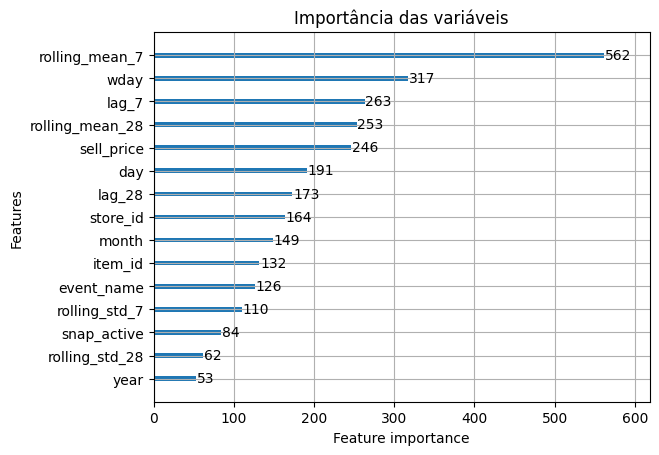

In [18]:
lgb.plot_importance(lgb_model, max_num_features=15)
plt.title("Importância das variáveis")
plt.show()

### tuning dos hiperparâmetros

In [24]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- amostra pra economizar RAM ---
# (frac — 0.7 = 70% do dataset)
X_train_small = X_train.sample(frac=0.7, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# --- Dataset para o LightGBM ---
train_data = lgb.Dataset(X_train_small, label=y_train_small)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# --- parâmetros básicos ---
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'device': 'gpu',
    'gpu_use_dp': False,  # usa float32
    'verbose': -1
}

# --- treino ---
model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.03,     # taxa menor = mais precisão
    num_leaves=63,          # mais folhas = mais complexidade (mas sem pesar muito)
    max_depth=10,           # limite pra evitar overfitting
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.05,
    reg_lambda=0.05,
    n_estimators=2000,      # mais iterações (com early stopping ele para antes)
    device='gpu',
    gpu_use_dp=False,
    random_state=42
)

print("Treinando modelo LightGBM (GPU)...")
model.fit(
    X_train_small, y_train_small,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)

# --- predição e avaliação ---
y_pred = model.predict(X_test)
rmse_score = rmse(y_test, y_pred)
print(f"RMSE final: {rmse_score:.4f}")

Treinando modelo LightGBM (GPU)...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 40316927, number of used features: 21
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-80GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (615.19 MB) transferred to GPU in 0.672935 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.123167
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.95152
[200]	valid_0's rmse: 1.93358
[300]	valid_0's rmse: 1.92877
[400]	valid_0's rmse: 1.92587
[500]	valid_0's rmse: 1.92439
[600]	valid_0's rmse: 1.92365
[700]	valid_0's rmse: 1.92308
[800]	valid_0's rmse: 1.92244
[900]	valid_0's rmse: 1.92166
[1000]	valid_0's rmse: 1.9216
Early stopping, best

## Salvar melhor modelo

In [25]:
joblib.dump(model, 'lightgbm_gpu_tunado.pkl')

['lightgbm_gpu_tunado.pkl']